<a href="https://colab.research.google.com/github/vibhananda28/Machine-Learning-Projects/blob/main/IMDB_dating_posts_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#IMPORTING LIBRARIES AND LOADING DATA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from more_itertools import take
from nltk import word_tokenize, pos_tag, pos_tag_sents
from typing import List
from more_itertools import take
import pickle
import nltk
import csv
import re
import spacy
import copy
import warnings
from scipy import stats
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import opinion_lexicon
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:

df_mbti = pd.read_csv("data.csv")

In [4]:
df_mbti.head()

index  id                                       title  \
0      0   7   What do INFJs look for in a relationship?   
1      1   9                         What do you prefer?   
2      2  11                     Secure-sexuals...unite!   
3      3  12  Which type makes the best actor/performer?   
4      4  14                        What makes you angry   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [5]:
df_mbti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   444 non-null    int64 
 1   id      444 non-null    int64 
 2   title   444 non-null    object
 3   texts   444 non-null    object
 4   labels  444 non-null    object
 5   forum   444 non-null    object
dtypes: int64(2), object(4)
memory usage: 20.9+ KB


We see that there are no missing values, 6 columns and 444 rows.

### PREPROCESSING

Check datatypes and convert to required type

In [6]:
#Convert object to string type
df_mbti["title"] = df_mbti["title"].astype("string")
df_mbti["texts"] = df_mbti["texts"].astype("string")
df_mbti["labels"] = df_mbti["labels"].astype("string")
df_mbti["forum"] = df_mbti["forum"].astype("string")

In [7]:
df_mbti.dtypes

index      int64
id         int64
title     string
texts     string
labels    string
forum     string
dtype: object

Splitting comments into separate rows

In [8]:
def obtain_sentences(s):
    sents = s.split("\",")
    tempsents = []
    for sent in sents:
      sents2 = sent.split("',")
      for sent2 in sents2:
        tempsents.append(sent2)
    return tempsents

In [9]:
df_mbti_comments = df_mbti
i = 0
df_mbti_comments['texts'] = df_mbti_comments.apply(lambda x: obtain_sentences(x['texts']), axis=1)
df_mbti_comments = df_mbti_comments.explode('texts').reset_index(drop=True)

In [10]:
df_mbti_comments

,index,id,title,texts,labels,forum
0,0,7,What do INFJs look for in a relationship?,"[""I'm an INFJ, and so far I have not had any luck finding someone that I really like. I can pretty much get along with anyone, but I'm wondering if I can ever be in a relationship that is truly passionate. Project Evolove says I'm most attracted to those with my own instincts and those who are ENTP/ENFPs. So far I have dated an INTJ and an INFP (but I don't know what their instincts are). Any other INFJs out there want to share their experiences with ENTPs or ENFPs?",['Dating & Relationships'],Dating & Relationships
1,0,7,What do INFJs look for in a relationship?,"'Personally, I would rather be with my own kind (INFJ) than any other type. Yet, I always end up with INTJs (who I have a magnetic attraction with).",['Dating & Relationships'],Dating & Relationships
2,0,7,What do INFJs look for in a relationship?,"'Love, depth, compatibility, understanding and safety.",['Dating & Relationships'],Dating & Relationships
3,0,7,What do INFJs look for in a relationship?,"""Security, compassion, highly driven, good humor... I guess. That's what I'm looking for.",['Dating & Relationships'],Dating & Relationships
4,0,7,What do INFJs look for in a relationship?,"'Honesty, loyalty, love, concern, intelligence, wise, strong , friendly, polite, humble, reasoble, moral, just, understanding, respectful, considerate, and artstic.",['Dating & Relationships'],Dating & Relationships
...,...,...,...,...,...,...
4083,443,518,How to get an INFP as an INTJ?,"'hmm, ok, I understand. My failure is that I kinda let my emotions screw me. I believe that you are highly probably right. I guess I will try to recover from that and I will probably restrict my communication with her. Thank you for advice and thoughts. I really appreciate that.","['Romantics ', 'Personality', 'INFP - Healer']",INFP - Healer
4084,443,518,How to get an INFP as an INTJ?,"'Also @isochroma, I beg to differ. INTJs are very attractive. Their dark, brooding intensity is beguiling :P","['Romantics ', 'Personality', 'INFP - Healer']",INFP - Healer
4085,443,518,How to get an INFP as an INTJ?,'another fantastic answer you are absolutely on fire today,"['Romantics ', 'Personality', 'INFP - Healer']",INFP - Healer
4086,443,518,How to get an INFP as an INTJ?,"""I types have a hard time meeting other I types of the opposite sex. Its like the I's don't get out of their comfort zones readily and the E types have already swooped in and snatched up all the chicadees, that they lack the patience to appreciate, and keep them hidden wrapped up and constantly preoccupied.","['Romantics ', 'Personality', 'INFP - Healer']",INFP - Healer


In [11]:
len(df_mbti_comments)

4088

In [12]:
df_mbti_comments.dtypes

index      int64
id         int64
title     string
texts     object
labels    string
forum     string
dtype: object

In [13]:
#Convert object to string type in new df

df_mbti_comments["title"] = df_mbti_comments["title"].astype("string")
df_mbti_comments["texts"] = df_mbti_comments["texts"].astype("string")
df_mbti_comments["labels"] = df_mbti_comments["labels"].astype("string")
df_mbti_comments["forum"] = df_mbti_comments["forum"].astype("string")

Convert all text to lowercase

In [14]:
df_mbti_comments["title"] = df_mbti_comments["title"].str.lower()
df_mbti_comments["texts"] = df_mbti_comments["texts"].str.lower()

Removing all links

In [15]:
def remove_links(text):
  #links = re.findall(r'https?://\S+', text)
  links = re.findall(r'https?\S+', text)
  for link in links:
    text = text.replace(link, '')
  return text

In [16]:
df_mbti_comments["texts"] = df_mbti_comments["texts"].apply(remove_links)

In [17]:
def remove_http(text):
  links = re.findall(r'http://\S+|www\.\S+', text)
  for link in links:
    text = text.replace(link, '')
  return text

In [18]:
df_mbti_comments["texts"] = df_mbti_comments["texts"].apply(remove_http)

Removing hashtags (#) and account names (@) from the forum text

In [19]:
def remove_hash_account(text):
  return re.sub(r'#\w+|@\w+', ' ', text)

In [20]:
df_mbti_comments["title"] = df_mbti_comments["title"].apply(remove_hash_account)
df_mbti_comments["texts"] = df_mbti_comments["texts"].apply(remove_hash_account)

Removing non-alphanumeric characters from the texts

In [21]:
def remove_nonalpha(text):
  return re.sub('[^A-Za-z0-9]+', ' ', text)

In [22]:
df_mbti_comments["title"] = df_mbti_comments["title"].apply(remove_nonalpha)
df_mbti_comments["texts"] = df_mbti_comments["texts"].apply(remove_nonalpha)

Tokenization

In [23]:
nltk.download('punkt')

df_mbti_comments['TokenizedTexts'] = df_mbti_comments['texts'].apply(lambda x: word_tokenize(x))

df_mbti_comments[['texts', 'TokenizedTexts']].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,texts,TokenizedTexts
0,i m an infj and so far i have not had any luck finding someone that i really like i can pretty much get along with anyone but i m wondering if i can ever be in a relationship that is truly passionate project evolove says i m most attracted to those with my own instincts and those who are entp enfps so far i have dated an intj and an infp but i don t know what their instincts are any other infjs out there want to share their experiences with entps or enfps,"[i, m, an, infj, and, so, far, i, have, not, had, any, luck, finding, someone, that, i, really, like, i, can, pretty, much, get, along, with, anyone, but, i, m, wondering, if, i, can, ever, be, in, a, relationship, that, is, truly, passionate, project, evolove, says, i, m, most, attracted, to, those, with, my, own, instincts, and, those, who, are, entp, enfps, so, far, i, have, dated, an, intj, and, an, infp, but, i, don, t, know, what, their, instincts, are, any, other, infjs, out, there, want, to, share, their, experiences, with, entps, or, enfps]"
1,personally i would rather be with my own kind infj than any other type yet i always end up with intjs who i have a magnetic attraction with,"[personally, i, would, rather, be, with, my, own, kind, infj, than, any, other, type, yet, i, always, end, up, with, intjs, who, i, have, a, magnetic, attraction, with]"
2,love depth compatibility understanding and safety,"[love, depth, compatibility, understanding, and, safety]"
3,security compassion highly driven good humor i guess that s what i m looking for,"[security, compassion, highly, driven, good, humor, i, guess, that, s, what, i, m, looking, for]"
4,honesty loyalty love concern intelligence wise strong friendly polite humble reasoble moral just understanding respectful considerate and artstic,"[honesty, loyalty, love, concern, intelligence, wise, strong, friendly, polite, humble, reasoble, moral, just, understanding, respectful, considerate, and, artstic]"


Remove stopwords

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [26]:
df_mbti_comments['StopwordRemovedTexts'] = df_mbti_comments['TokenizedTexts'].apply(lambda x: [item for item in x if item not in stop])

In [27]:
df_mbti_comments[['StopwordRemovedTexts', 'TokenizedTexts']].head(5)

,StopwordRemovedTexts,TokenizedTexts
0,"[infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wondering, ever, relationship, truly, passionate, project, evolove, says, attracted, instincts, entp, enfps, far, dated, intj, infp, know, instincts, infjs, want, share, experiences, entps, enfps]","[i, m, an, infj, and, so, far, i, have, not, had, any, luck, finding, someone, that, i, really, like, i, can, pretty, much, get, along, with, anyone, but, i, m, wondering, if, i, can, ever, be, in, a, relationship, that, is, truly, passionate, project, evolove, says, i, m, most, attracted, to, those, with, my, own, instincts, and, those, who, are, entp, enfps, so, far, i, have, dated, an, intj, and, an, infp, but, i, don, t, know, what, their, instincts, are, any, other, infjs, out, there, want, to, share, their, experiences, with, entps, or, enfps]"
1,"[personally, would, rather, kind, infj, type, yet, always, end, intjs, magnetic, attraction]","[personally, i, would, rather, be, with, my, own, kind, infj, than, any, other, type, yet, i, always, end, up, with, intjs, who, i, have, a, magnetic, attraction, with]"
2,"[love, depth, compatibility, understanding, safety]","[love, depth, compatibility, understanding, and, safety]"
3,"[security, compassion, highly, driven, good, humor, guess, looking]","[security, compassion, highly, driven, good, humor, i, guess, that, s, what, i, m, looking, for]"
4,"[honesty, loyalty, love, concern, intelligence, wise, strong, friendly, polite, humble, reasoble, moral, understanding, respectful, considerate, artstic]","[honesty, loyalty, love, concern, intelligence, wise, strong, friendly, polite, humble, reasoble, moral, just, understanding, respectful, considerate, and, artstic]"


Tokenizing Title and Stopword removal

In [28]:
df_mbti_comments['TokenizedTitle'] = df_mbti_comments['title'].apply(lambda x: word_tokenize(x))

df_mbti_comments['StopwordRemovedTitle'] = df_mbti_comments['TokenizedTitle'].apply(lambda x: [item for item in x if item not in stop])

In [29]:
df_mbti_comments[['StopwordRemovedTitle', 'TokenizedTitle', 'title']].head(5)

,StopwordRemovedTitle,TokenizedTitle,title
0,"[infjs, look, relationship]","[what, do, infjs, look, for, in, a, relationship]",what do infjs look for in a relationship
1,"[infjs, look, relationship]","[what, do, infjs, look, for, in, a, relationship]",what do infjs look for in a relationship
2,"[infjs, look, relationship]","[what, do, infjs, look, for, in, a, relationship]",what do infjs look for in a relationship
3,"[infjs, look, relationship]","[what, do, infjs, look, for, in, a, relationship]",what do infjs look for in a relationship
4,"[infjs, look, relationship]","[what, do, infjs, look, for, in, a, relationship]",what do infjs look for in a relationship


Combining Title and Texts tokens

In [30]:
def combine_lists(row):
    return row['StopwordRemovedTitle'] + row['StopwordRemovedTexts']

In [31]:
df_mbti_comments['TextsTitleTokens'] = df_mbti_comments.apply(combine_lists, axis=1)

In [32]:
df_mbti_comments[['StopwordRemovedTitle', 'StopwordRemovedTexts', 'TextsTitleTokens']].head(5)

,StopwordRemovedTitle,StopwordRemovedTexts,TextsTitleTokens
0,"[infjs, look, relationship]","[infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wondering, ever, relationship, truly, passionate, project, evolove, says, attracted, instincts, entp, enfps, far, dated, intj, infp, know, instincts, infjs, want, share, experiences, entps, enfps]","[infjs, look, relationship, infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wondering, ever, relationship, truly, passionate, project, evolove, says, attracted, instincts, entp, enfps, far, dated, intj, infp, know, instincts, infjs, want, share, experiences, entps, enfps]"
1,"[infjs, look, relationship]","[personally, would, rather, kind, infj, type, yet, always, end, intjs, magnetic, attraction]","[infjs, look, relationship, personally, would, rather, kind, infj, type, yet, always, end, intjs, magnetic, attraction]"
2,"[infjs, look, relationship]","[love, depth, compatibility, understanding, safety]","[infjs, look, relationship, love, depth, compatibility, understanding, safety]"
3,"[infjs, look, relationship]","[security, compassion, highly, driven, good, humor, guess, looking]","[infjs, look, relationship, security, compassion, highly, driven, good, humor, guess, looking]"
4,"[infjs, look, relationship]","[honesty, loyalty, love, concern, intelligence, wise, strong, friendly, polite, humble, reasoble, moral, understanding, respectful, considerate, artstic]","[infjs, look, relationship, honesty, loyalty, love, concern, intelligence, wise, strong, friendly, polite, humble, reasoble, moral, understanding, respectful, considerate, artstic]"


Stemming

In [33]:
# Using Snowball Stemmer

from nltk.stem import SnowballStemmer

ss = SnowballStemmer("english")

def stem_tokens(tokens):
    return [ss.stem(word) for word in tokens]

df_mbti_comments['StemmedTexts'] = df_mbti_comments['StopwordRemovedTexts'].apply(stem_tokens)
df_mbti_comments['StemmedTitle'] = df_mbti_comments['StopwordRemovedTitle'].apply(stem_tokens)
df_mbti_comments['StemmedTextsTitle'] = df_mbti_comments['TextsTitleTokens'].apply(stem_tokens)

df_mbti_comments[['StemmedTextsTitle', 'TextsTitleTokens']].head(5)

,StemmedTextsTitle,TextsTitleTokens
0,"[infj, look, relationship, infj, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, entp, enfp, far, date, intj, infp, know, instinct, infj, want, share, experi, entp, enfp]","[infjs, look, relationship, infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wondering, ever, relationship, truly, passionate, project, evolove, says, attracted, instincts, entp, enfps, far, dated, intj, infp, know, instincts, infjs, want, share, experiences, entps, enfps]"
1,"[infj, look, relationship, person, would, rather, kind, infj, type, yet, alway, end, intj, magnet, attract]","[infjs, look, relationship, personally, would, rather, kind, infj, type, yet, always, end, intjs, magnetic, attraction]"
2,"[infj, look, relationship, love, depth, compat, understand, safeti]","[infjs, look, relationship, love, depth, compatibility, understanding, safety]"
3,"[infj, look, relationship, secur, compass, high, driven, good, humor, guess, look]","[infjs, look, relationship, security, compassion, highly, driven, good, humor, guess, looking]"
4,"[infj, look, relationship, honesti, loyalti, love, concern, intellig, wise, strong, friend, polit, humbl, reasobl, moral, understand, respect, consider, artstic]","[infjs, look, relationship, honesty, loyalty, love, concern, intelligence, wise, strong, friendly, polite, humble, reasoble, moral, understanding, respectful, considerate, artstic]"


Remvong MBTIs from StemmedTextsTitle for future modeling

In [34]:
def remove_mbti(word_list):

    http_list = ['http', 'nhttp', 'us', 'net', 'n']

    mbti_pattern = r'\b[ie][ns][tf][jp]\b'

    return [word for word in word_list if not (re.match(mbti_pattern, word) or word in http_list)]

In [35]:
# Apply the remove_mbti function to the 'stemmed_tokens' column
df_mbti_comments['Tokens_without_mbti'] = df_mbti_comments['StemmedTextsTitle'].apply(remove_mbti)

df_mbti_comments[['Tokens_without_mbti', 'StemmedTextsTitle']].head(5)

,Tokens_without_mbti,StemmedTextsTitle
0,"[look, relationship, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, far, date, know, instinct, want, share, experi]","[infj, look, relationship, infj, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, entp, enfp, far, date, intj, infp, know, instinct, infj, want, share, experi, entp, enfp]"
1,"[look, relationship, person, would, rather, kind, type, yet, alway, end, magnet, attract]","[infj, look, relationship, person, would, rather, kind, infj, type, yet, alway, end, intj, magnet, attract]"
2,"[look, relationship, love, depth, compat, understand, safeti]","[infj, look, relationship, love, depth, compat, understand, safeti]"
3,"[look, relationship, secur, compass, high, driven, good, humor, guess, look]","[infj, look, relationship, secur, compass, high, driven, good, humor, guess, look]"
4,"[look, relationship, honesti, loyalti, love, concern, intellig, wise, strong, friend, polit, humbl, reasobl, moral, understand, respect, consider, artstic]","[infj, look, relationship, honesti, loyalti, love, concern, intellig, wise, strong, friend, polit, humbl, reasobl, moral, understand, respect, consider, artstic]"


Extracting MBTI labels from title and text columns

In [36]:
all_mbti_types = ['infj', 'intj', 'infp', 'intp', 'isfj', 'istj', 'enfj', 'entj', 'enfp', 'entp', 'esfj', 'estj', 'istp', 'isfp', 'estp', 'esfp']

def extract_mbti(row):

    mbti_from_title = [token for token in row['StemmedTitle'] if token in all_mbti_types]

    mbti_from_text = [token for token in row['StemmedTexts'] if token in all_mbti_types]

    # Calculate the frequency of each MBTI token in StemmedTextsTitle_snowball
    mbti_counts = Counter(mbti_from_text)

    # Find the maximum count
    max_count = max(mbti_counts.values(), default=0)

    # Create a list of MBTI tokens with the maximum count
    unique_mbti_labels = list(set(mbti_from_title + [mbti for mbti, count in mbti_counts.items() if count == max_count]))

    return unique_mbti_labels

In [37]:
# Apply the function to each row and store the results in a new column 'ExtractedMBTI'
df_mbti_comments['MBTI labels'] = df_mbti_comments.apply(extract_mbti, axis=1)

df_mbti_comments[['StemmedTitle', 'StemmedTexts', 'MBTI labels']].head(20)

,StemmedTitle,StemmedTexts,MBTI labels
0,"[infj, look, relationship]","[infj, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, entp, enfp, far, date, intj, infp, know, instinct, infj, want, share, experi, entp, enfp]","[infj, entp, enfp]"
1,"[infj, look, relationship]","[person, would, rather, kind, infj, type, yet, alway, end, intj, magnet, attract]","[infj, intj]"
2,"[infj, look, relationship]","[love, depth, compat, understand, safeti]",[infj]
3,"[infj, look, relationship]","[secur, compass, high, driven, good, humor, guess, look]",[infj]
4,"[infj, look, relationship]","[honesti, loyalti, love, concern, intellig, wise, strong, friend, polit, humbl, reasobl, moral, understand, respect, consider, artstic]",[infj]
5,"[infj, look, relationship]","[love, date, anoth, infj, someon, passion, driven, like, laugh]",[infj]
6,"[infj, look, relationship]","[well, would, like, someon, relax, nonjudgment, accept, mental, emot, stabl, ish, someon, like, humor, afraid, experi, passion, de, sade, would, call, among, thing, surpris, quit, high, demand]",[infj]
7,"[infj, look, relationship]","[would, like, someon, talk, think, much, depth, relationship, outsid, infj, know, last, relationship, need, someon, communic, verbal, emot, n, nmi, partner, would, also, best, friend, loyalti, passion, would, focus, one, individu, understand, nf, see, someon, like, open, becom, fierc, loyal, fault, n, ni, think, peopl, like, clingi, men, touchi, feeli, men, tend, shi, mani, us, misunderstood, shame, realli]",[infj]
8,"[infj, look, relationship]","[entp, short, time, say, great, although, short, although, say, think, mani, type, would, prefer, feeler, possibl, infj, howev, might, unrealist, find, one, live, close, sinc, far]","[infj, entp]"
9,"[infj, look, relationship]","[crush, entp, friend, enfp, realli, think, wonder, drawn, abil, make, feel, aliv, also, skeptic, two, unsur, whether, capabl, keep, sinc, shi, believ, may, becom, irrit, one, handl, social, situat, issu, though]","[infj, entp, enfp]"


Removing rows without MBTI labels

In [38]:
# Filter rows with non-empty 'mbti' lists
df_mbti_comments_without_mbti_labels = df_mbti_comments[df_mbti_comments['MBTI labels'].apply(lambda x: len(x) == 0)]

# Filter rows with non-empty 'mbti' lists
df_mbti_labels = df_mbti_comments[df_mbti_comments['MBTI labels'].apply(lambda x: len(x) > 0)]

# Reset the index if needed
df_mbti_labels.reset_index(drop=True, inplace=True)

In [39]:
num_rows_before = len(df_mbti_comments)
num_rows_to_remove = len(df_mbti_comments_without_mbti_labels)
num_rows_after = len(df_mbti_labels)

print("Number of rows before removing rows", num_rows_before, "Number of rows to remove", num_rows_to_remove, "Number of rows after removing rows", num_rows_after)

Number of rows before removing rows 4088 Number of rows to remove 2056 Number of rows after removing rows 2032


In [40]:
#Dataframe without mbti labels

df_mbti_comments_without_mbti_labels[['StemmedTextsTitle', 'MBTI labels']].head(5)

,StemmedTextsTitle,MBTI labels
16,"[prefer, sexual, social, never, realli, use, instinct, analyz, girlfriend, read, descript, realiz, past, girlfriend, sexual, secur, social, sexual, like, differ, way, end, break, anoth, stori, want, opinion, sexual, social, prefer, three, suppos, match, anoth, sexual, social, sexual, secur, social, sexual]",[]
17,"[prefer, hey, prefer, primari, sexual, alway, intens, one, one, connect, import, far, secondari, think, prefer, secur, secondari, type, realli, want, someon, may, priorit, social, one, one, often]",[]
18,"[prefer, hmm, sure, nwhich, type, open, mind, toward, 3, way, either, gender, recreat, sexual, activ, novel, locat]",[]
19,"[prefer, prefer, sexual, secur, could, see, sexual, social]",[]
20,"[prefer, expos, instinct, site, read, descript, definit, gravit, toward, sexual, secur, sexual, social, natur, n, n]",[]


In [41]:
df_mbti_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4088 entries, 0 to 4087
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 4088 non-null   int64 
 1   id                    4088 non-null   int64 
 2   title                 4088 non-null   object
 3   texts                 4088 non-null   object
 4   labels                4088 non-null   string
 5   forum                 4088 non-null   string
 6   TokenizedTexts        4088 non-null   object
 7   StopwordRemovedTexts  4088 non-null   object
 8   TokenizedTitle        4088 non-null   object
 9   StopwordRemovedTitle  4088 non-null   object
 10  TextsTitleTokens      4088 non-null   object
 11  StemmedTexts          4088 non-null   object
 12  StemmedTitle          4088 non-null   object
 13  StemmedTextsTitle     4088 non-null   object
 14  Tokens_without_mbti   4088 non-null   object
 15  MBTI labels           4088 non-null   

In [42]:
df_mbti_labels = df_mbti_labels.explode('MBTI labels')

In [43]:
df_mbti_labels.head(20)

,index,id,title,texts,labels,forum,TokenizedTexts,StopwordRemovedTexts,TokenizedTitle,StopwordRemovedTitle,TextsTitleTokens,StemmedTexts,StemmedTitle,StemmedTextsTitle,Tokens_without_mbti,MBTI labels
0,0,7,what do infjs look for in a relationship,i m an infj and so far i have not had any luck finding someone that i really like i can pretty much get along with anyone but i m wondering if i can ever be in a relationship that is truly passionate project evolove says i m most attracted to those with my own instincts and those who are entp enfps so far i have dated an intj and an infp but i don t know what their instincts are any other infjs out there want to share their experiences with entps or enfps,['Dating & Relationships'],Dating & Relationships,"[i, m, an, infj, and, so, far, i, have, not, had, any, luck, finding, someone, that, i, really, like, i, can, pretty, much, get, along, with, anyone, but, i, m, wondering, if, i, can, ever, be, in, a, relationship, that, is, truly, passionate, project, evolove, says, i, m, most, attracted, to, those, with, my, own, instincts, and, those, who, are, entp, enfps, so, far, i, have, dated, an, intj, and, an, infp, but, i, don, t, know, what, their, instincts, are, any, other, infjs, out, there, want, to, share, their, experiences, with, entps, or, enfps]","[infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wondering, ever, relationship, truly, passionate, project, evolove, says, attracted, instincts, entp, enfps, far, dated, intj, infp, know, instincts, infjs, want, share, experiences, entps, enfps]","[what, do, infjs, look, for, in, a, relationship]","[infjs, look, relationship]","[infjs, look, relationship, infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wondering, ever, relationship, truly, passionate, project, evolove, says, attracted, instincts, entp, enfps, far, dated, intj, infp, know, instincts, infjs, want, share, experiences, entps, enfps]","[infj, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, entp, enfp, far, date, intj, infp, know, instinct, infj, want, share, experi, entp, enfp]","[infj, look, relationship]","[infj, look, relationship, infj, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, entp, enfp, far, date, intj, infp, know, instinct, infj, want, share, experi, entp, enfp]","[look, relationship, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, far, date, know, instinct, want, share, experi]",infj
0,0,7,what do infjs look for in a relationship,i m an infj and so far i have not had any luck finding someone that i really like i can pretty much get along with anyone but i m wondering if i can ever be in a relationship that is truly passionate project evolove says i m most attracted to those with my own instincts and those who are entp enfps so far i have dated an intj and an infp but i don t know what their instincts are any other infjs out there want to share their experiences with entps or enfps,['Dating & Relationships'],Dating & Relationships,"[i, m, an, infj, and, so, far, i, have, not, had, any, luck, finding, someone, that, i, really, like, i, can, pretty, much, get, along, with, anyone, but, i, m, wondering, if, i, can, ever, be, in, a, relationship, that, is, truly, passionate, project, evolove, says, i, m, most, attracted, to, those, with, my, own, instincts, and, those, who, are, entp, enfps, so, far, i, have, dated, an, intj, and, an, infp, but, i, don, t, know, what, their, instincts, are, any, other, infjs, out, there, want, to, share, their, experiences, with, entps, or, enfps]","[infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wondering,

In [44]:
num_rows_after_exploding = len(df_mbti_labels)

num_rows_after_exploding

2827

# EDA AND FEATURE EXTRACTION

In [45]:
df_mbti_labels = df_mbti_labels.drop("index", axis=1)

In [46]:
df_mbti_labels.shape

(2827, 15)

In [47]:
df_mbti_labels.head()

,id,title,texts,labels,forum,TokenizedTexts,StopwordRemovedTexts,TokenizedTitle,StopwordRemovedTitle,TextsTitleTokens,StemmedTexts,StemmedTitle,StemmedTextsTitle,Tokens_without_mbti,MBTI labels
0,7,what do infjs look for in a relationship,i m an infj and so far i have not had any luck finding someone that i really like i can pretty much get along with anyone but i m wondering if i can ever be in a relationship that is truly passionate project evolove says i m most attracted to those with my own instincts and those who are entp enfps so far i have dated an intj and an infp but i don t know what their instincts are any other infjs out there want to share their experiences with entps or enfps,['Dating & Relationships'],Dating & Relationships,"[i, m, an, infj, and, so, far, i, have, not, had, any, luck, finding, someone, that, i, really, like, i, can, pretty, much, get, along, with, anyone, but, i, m, wondering, if, i, can, ever, be, in, a, relationship, that, is, truly, passionate, project, evolove, says, i, m, most, attracted, to, those, with, my, own, instincts, and, those, who, are, entp, enfps, so, far, i, have, dated, an, intj, and, an, infp, but, i, don, t, know, what, their, instincts, are, any, other, infjs, out, there, want, to, share, their, experiences, with, entps, or, enfps]","[infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wondering, ever, relationship, truly, passionate, project, evolove, says, attracted, instincts, entp, enfps, far, dated, intj, infp, know, instincts, infjs, want, share, experiences, entps, enfps]","[what, do, infjs, look, for, in, a, relationship]","[infjs, look, relationship]","[infjs, look, relationship, infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wondering, ever, relationship, truly, passionate, project, evolove, says, attracted, instincts, entp, enfps, far, dated, intj, infp, know, instincts, infjs, want, share, experiences, entps, enfps]","[infj, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, entp, enfp, far, date, intj, infp, know, instinct, infj, want, share, experi, entp, enfp]","[infj, look, relationship]","[infj, look, relationship, infj, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, entp, enfp, far, date, intj, infp, know, instinct, infj, want, share, experi, entp, enfp]","[look, relationship, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, far, date, know, instinct, want, share, experi]",infj
0,7,what do infjs look for in a relationship,i m an infj and so far i have not had any luck finding someone that i really like i can pretty much get along with anyone but i m wondering if i can ever be in a relationship that is truly passionate project evolove says i m most attracted to those with my own instincts and those who are entp enfps so far i have dated an intj and an infp but i don t know what their instincts are any other infjs out there want to share their experiences with entps or enfps,['Dating & Relationships'],Dating & Relationships,"[i, m, an, infj, and, so, far, i, have, not, had, any, luck, finding, someone, that, i, really, like, i, can, pretty, much, get, along, with, anyone, but, i, m, wondering, if, i, can, ever, be, in, a, relationship, that, is, truly, passionate, project, evolove, says, i, m, most, attracted, to, those, with, my, own, instincts, and, those, who, are, entp, enfps, so, far, i, have, dated, an, intj, and, an, infp, but, i, don, t, know, what, their, instincts, are, any, other, infjs, out, there, want, to, share, their, experiences, with, entps, or, enfps]","[infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wondering, ever, rel

In [48]:
#flattened_labels = [label for sublist in df_mbti_labels['MBTI labels'] for label in sublist]

In [49]:
flattened_labels = df_mbti_labels['MBTI labels']

In [50]:
#label_counts = pd.Series(flattened_labels).value_counts()

In [51]:
label_counts = pd.Series(flattened_labels).value_counts()

In [52]:
print(label_counts)

intj    559
infj    461
intp    424
enfp    356
infp    272
entp    199
entj    115
istj     83
istp     74
enfj     62
isfp     55
esfj     55
estj     46
esfp     31
isfj     24
estp     11
Name: MBTI labels, dtype: int64


<Axes: title={'center': 'Count of Personality type'}>

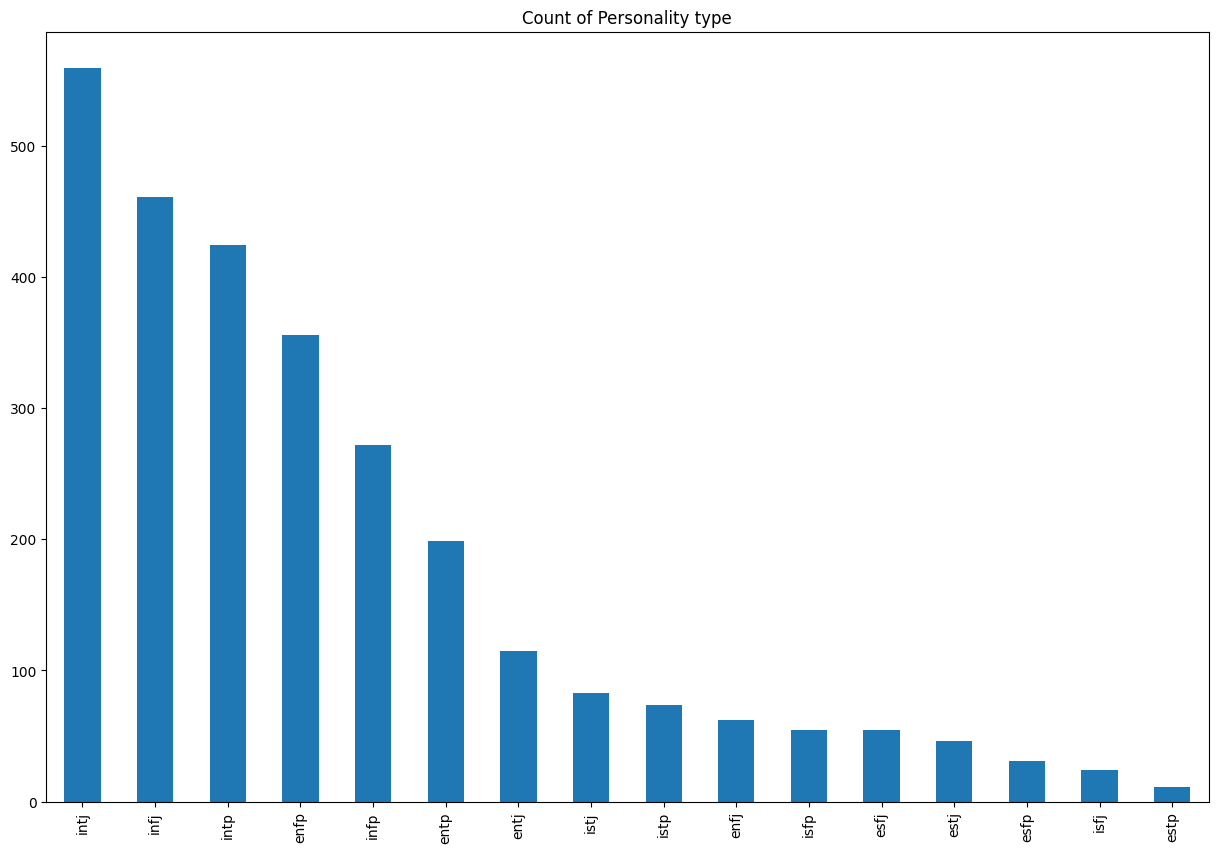

In [53]:
plt.figure(figsize=(15,10))
label_counts.plot(kind='bar',title="Count of Personality type")

We have some imbalanced data here with overrepresentation of some personality types.

Text(0.5, 1.0, 'Distribution of Lengths of all Posts')

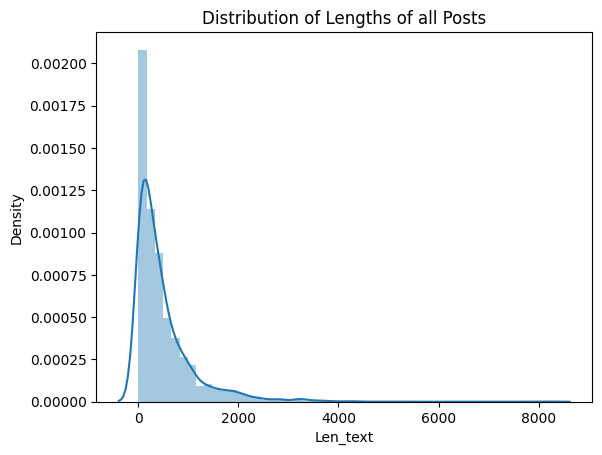

In [54]:
df_mbti_labels["Len_text"] = df_mbti_labels["texts"].apply(len)
sns.distplot(df_mbti_labels["Len_text"]).set_title("Distribution of Lengths of all Posts")

In [55]:
df_mbti_labels_split = {
    'mbti_label': 'flattened_labels',
    'id': df_mbti_labels['id'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'title': df_mbti_labels['title'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'texts': df_mbti_labels['texts'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'labels': df_mbti_labels['labels'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'forum': df_mbti_labels['forum'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'Len_text': df_mbti_labels['Len_text'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'TokenizedTexts': df_mbti_labels['TokenizedTexts'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'StopwordRemovedTexts': df_mbti_labels['StopwordRemovedTexts'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'TokenizedTitle': df_mbti_labels['TokenizedTitle'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'StopwordRemovedTitle': df_mbti_labels['StopwordRemovedTitle'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'TextsTitleTokens': df_mbti_labels['TextsTitleTokens'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'StemmedTexts': df_mbti_labels['StemmedTexts'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'StemmedTitle': df_mbti_labels['StemmedTitle'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'StemmedTextsTitle': df_mbti_labels['StemmedTextsTitle'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'Tokens_without_mbti': df_mbti_labels['Tokens_without_mbti'].repeat(df_mbti_labels['MBTI labels'].apply(len)),
    'MBTI labels': df_mbti_labels['MBTI labels'].repeat(df_mbti_labels['MBTI labels'].apply(len))}

In [56]:
#df_mbti_labels_split = pd.DataFrame(df_mbti_labels_split)

In [57]:
df_mbti_labels_split = pd.DataFrame(df_mbti_labels)

In [58]:
df_mbti_labels_split = df_mbti_labels_split.reset_index(drop=True)

In [59]:
df_mbti_labels_split.head(10)

,id,title,texts,labels,forum,TokenizedTexts,StopwordRemovedTexts,TokenizedTitle,StopwordRemovedTitle,TextsTitleTokens,StemmedTexts,StemmedTitle,StemmedTextsTitle,Tokens_without_mbti,MBTI labels,Len_text
0,7,what do infjs look for in a relationship,i m an infj and so far i have not had any luck finding someone that i really like i can pretty much get along with anyone but i m wondering if i can ever be in a relationship that is truly passionate project evolove says i m most attracted to those with my own instincts and those who are entp enfps so far i have dated an intj and an infp but i don t know what their instincts are any other infjs out there want to share their experiences with entps or enfps,['Dating & Relationships'],Dating & Relationships,"[i, m, an, infj, and, so, far, i, have, not, had, any, luck, finding, someone, that, i, really, like, i, can, pretty, much, get, along, with, anyone, but, i, m, wondering, if, i, can, ever, be, in, a, relationship, that, is, truly, passionate, project, evolove, says, i, m, most, attracted, to, those, with, my, own, instincts, and, those, who, are, entp, enfps, so, far, i, have, dated, an, intj, and, an, infp, but, i, don, t, know, what, their, instincts, are, any, other, infjs, out, there, want, to, share, their, experiences, with, entps, or, enfps]","[infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wondering, ever, relationship, truly, passionate, project, evolove, says, attracted, instincts, entp, enfps, far, dated, intj, infp, know, instincts, infjs, want, share, experiences, entps, enfps]","[what, do, infjs, look, for, in, a, relationship]","[infjs, look, relationship]","[infjs, look, relationship, infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wondering, ever, relationship, truly, passionate, project, evolove, says, attracted, instincts, entp, enfps, far, dated, intj, infp, know, instincts, infjs, want, share, experiences, entps, enfps]","[infj, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, entp, enfp, far, date, intj, infp, know, instinct, infj, want, share, experi, entp, enfp]","[infj, look, relationship]","[infj, look, relationship, infj, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, entp, enfp, far, date, intj, infp, know, instinct, infj, want, share, experi, entp, enfp]","[look, relationship, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, far, date, know, instinct, want, share, experi]",infj,461
1,7,what do infjs look for in a relationship,i m an infj and so far i have not had any luck finding someone that i really like i can pretty much get along with anyone but i m wondering if i can ever be in a relationship that is truly passionate project evolove says i m most attracted to those with my own instincts and those who are entp enfps so far i have dated an intj and an infp but i don t know what their instincts are any other infjs out there want to share their experiences with entps or enfps,['Dating & Relationships'],Dating & Relationships,"[i, m, an, infj, and, so, far, i, have, not, had, any, luck, finding, someone, that, i, really, like, i, can, pretty, much, get, along, with, anyone, but, i, m, wondering, if, i, can, ever, be, in, a, relationship, that, is, truly, passionate, project, evolove, says, i, m, most, attracted, to, those, with, my, own, instincts, and, those, who, are, entp, enfps, so, far, i, have, dated, an, intj, and, an, infp, but, i, don, t, know, what, their, instincts, are, any, other, infjs, out, there, want, to, share, their, experiences, with, entps, or, enfps]","[infj, far, luck, finding, someone, really, like, pretty, much, get, along, anyone, wonderi

In [60]:
import string
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import word_tokenize

In [61]:
grouped_wordclouds = df_mbti_labels_split[['MBTI labels','Tokens_without_mbti']]
grouped_wordclouds = grouped_wordclouds.groupby('MBTI labels').sum()
grouped_wordclouds = grouped_wordclouds.reset_index()

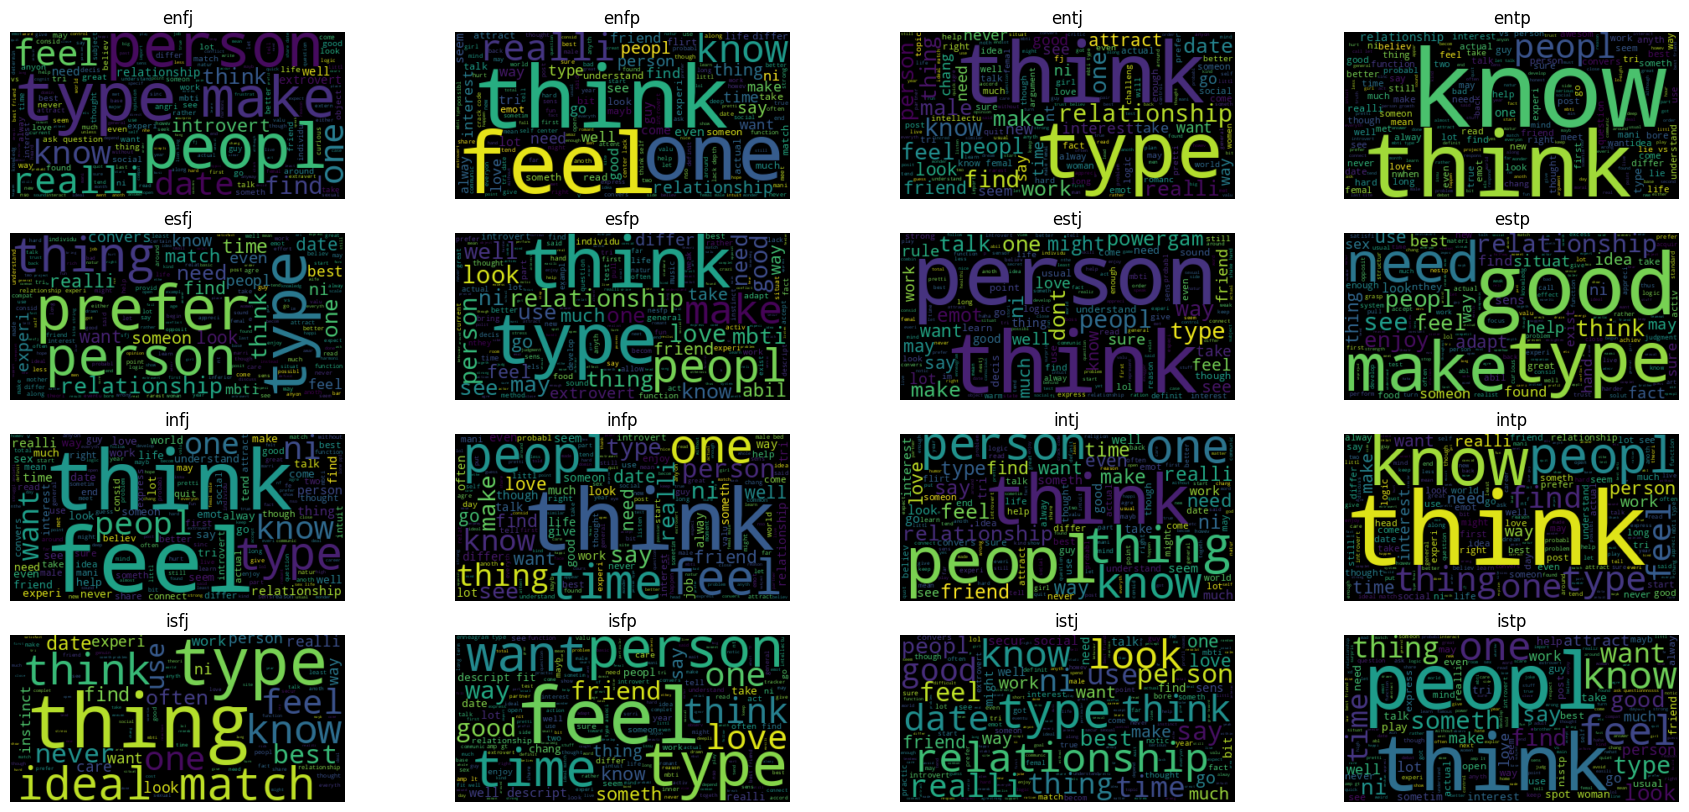

In [62]:
# Instatiate figure and axis and the number of subplots to use
fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_size_inches(22, 10)

# Create a list containing all the words for all the personalities then loop through these creating a wordcloud for each one
random = grouped_wordclouds['Tokens_without_mbti']
for i, j in grouped_wordclouds.iterrows():
    text = ', '.join(random[i])

    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)

    # Display the generated images:
    plt.subplot(4, 4, (i+1))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(str(grouped_wordclouds['MBTI labels'].iloc[i]))

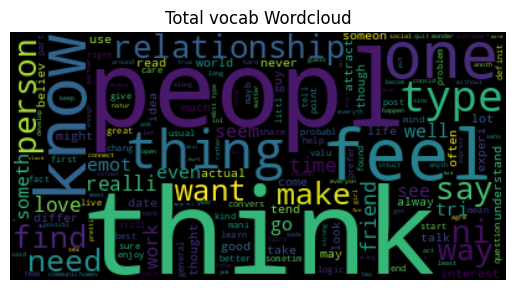

In [63]:
grouped_wordclouds = grouped_wordclouds['Tokens_without_mbti']

vocab = []
for i in random:
    vocab.append(i)

flat_vocab = []
for sublist in vocab:
    for item in sublist:
        flat_vocab.append(item)

text = ', '.join(word for word in flat_vocab)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Total vocab Wordcloud')
plt.show()

TF-IDF

TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions


In [64]:
def dummy_fun(doc):
    return doc

In [65]:
tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None)
tfidf.fit(df_mbti_labels_split["Tokens_without_mbti"])

TfidfVectorizer(preprocessor=<function dummy_fun at 0x7df6fa049870>,
                token_pattern=None,
                tokenizer=<function dummy_fun at 0x7df6fa049870>)

In [66]:
tfidf_vector = tfidf.transform(df_mbti_labels_split["Tokens_without_mbti"])

In [67]:
tfidf_vector.shape

(2827, 7780)

In [68]:
df_mbti_labels_split['mbti_label_numerical'] = pd.factorize(df_mbti_labels_split['MBTI labels'])[0]

In [69]:
df_mbti_labels_split['mbti_label_numerical'].value_counts()

3     559
0     461
7     424
2     356
4     272
1     199
13    115
10     83
11     74
9      62
8      55
15     55
14     46
5      31
12     24
6      11
Name: mbti_label_numerical, dtype: int64

In [70]:
X = df_mbti_labels_split["Tokens_without_mbti"].copy()
y = df_mbti_labels_split['mbti_label_numerical']

In [71]:
# Split the data into train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [72]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# MODELLING AND ANALYSIS

NAIVE BAYES

In [73]:
#Naive Bayes classifier
tfidf_nb_model = MultinomialNB()
tfidf_nb_model.fit(X_train_tfidf, y_train)
tfidf_nb_y_train_pred = tfidf_nb_model.predict(X_train_tfidf)

In [74]:
tfidf_nb_y_test_pred = tfidf_nb_model.predict(X_test_tfidf)

In [75]:
print ("Testing - Overall accuracy using Naive Bayes model: {0}\n".format(accuracy_score(y_test, tfidf_nb_y_test_pred)))
print (classification_report(y_test, tfidf_nb_y_test_pred))
print (confusion_matrix(y_test, tfidf_nb_y_test_pred))

Testing - Overall accuracy using Naive Bayes model: 0.2697290930506478

              precision    recall  f1-score   support

           0       0.37      0.33      0.35       138
           1       1.00      0.02      0.03        61
           2       0.40      0.10      0.16       100
           3       0.22      0.90      0.36       159
           4       1.00      0.05      0.09        82
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         4
           7       0.42      0.18      0.25       140
           8       0.00      0.00      0.00        19
           9       0.00      0.00      0.00        16
          10       0.00      0.00      0.00        24
          11       0.00      0.00      0.00        25
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00        36
          14       0.00      0.00      0.00        16
          15       0.00      0.00      0.00        15

    accu

XGBOOST

In [76]:
tfidf_xgb_model = XGBClassifier()
tfidf_xgb_model = tfidf_xgb_model.fit(X_train_tfidf, y_train)
tfidf_xgb_y_train_pred = tfidf_xgb_model.predict(X_train_tfidf)

In [77]:
tfidf_xgb_y_test_pred = tfidf_xgb_model.predict(X_test_tfidf)

In [78]:
print ("Testing - Overall accuracy using XGBOOST model: {0}\n".format(accuracy_score(y_test, tfidf_xgb_y_test_pred)))
print (classification_report(y_test, tfidf_xgb_y_test_pred))
print (confusion_matrix(y_test, tfidf_xgb_y_test_pred))

Testing - Overall accuracy using XGBOOST model: 0.2968197879858657

              precision    recall  f1-score   support

           0       0.31      0.36      0.33       138
           1       0.27      0.15      0.19        61
           2       0.25      0.28      0.26       100
           3       0.29      0.40      0.34       159
           4       0.33      0.29      0.31        82
           5       0.12      0.14      0.13         7
           6       0.00      0.00      0.00         4
           7       0.38      0.32      0.35       140
           8       0.43      0.32      0.36        19
           9       0.23      0.19      0.21        16
          10       0.38      0.25      0.30        24
          11       0.64      0.36      0.46        25
          12       0.00      0.00      0.00         7
          13       0.10      0.08      0.09        36
          14       0.40      0.25      0.31        16
          15       0.07      0.07      0.07        15

    accuracy

LOGISTIC REGRESSION

In [79]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_tfidf, y_train)
predict_tfidf_lr_y_train_predons = lr_classifier.predict(X_train_tfidf)

In [80]:
predict_tfidf_lr_y_test_predons = lr_classifier.predict(X_test_tfidf)

In [81]:
print ("Testing - Overall accuracy using Logistic Regression model: {0}\n".format(accuracy_score(y_test, predict_tfidf_lr_y_test_predons)))
print (classification_report(y_test, predict_tfidf_lr_y_test_predons))
print (confusion_matrix(y_test, predict_tfidf_lr_y_test_predons))

Testing - Overall accuracy using Logistic Regression model: 0.32273262661955243

              precision    recall  f1-score   support

           0       0.36      0.45      0.40       138
           1       0.37      0.11      0.17        61
           2       0.28      0.25      0.26       100
           3       0.29      0.63      0.39       159
           4       0.49      0.21      0.29        82
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         4
           7       0.32      0.38      0.34       140
           8       0.83      0.26      0.40        19
           9       1.00      0.06      0.12        16
          10       0.00      0.00      0.00        24
          11       1.00      0.04      0.08        25
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00        36
          14       1.00      0.12      0.22        16
          15       0.33      0.07      0.11        15


Support Vector Machine (SVM)

In [82]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)
tfidf_svc_y_test_pred = svm_classifier.predict(X_test_tfidf)

In [83]:
print ("Testing - Overall accuracy using Support Vector Machine model: {0}\n".format(accuracy_score(y_test, tfidf_svc_y_test_pred)))
print (classification_report(y_test, tfidf_svc_y_test_pred))
print (confusion_matrix(y_test, tfidf_svc_y_test_pred))

Testing - Overall accuracy using Support Vector Machine model: 0.30859835100117783

              precision    recall  f1-score   support

           0       0.33      0.43      0.38       138
           1       0.33      0.13      0.19        61
           2       0.26      0.24      0.25       100
           3       0.30      0.56      0.39       159
           4       0.40      0.23      0.29        82
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         4
           7       0.30      0.35      0.32       140
           8       0.71      0.26      0.38        19
           9       0.29      0.12      0.17        16
          10       0.00      0.00      0.00        24
          11       0.50      0.08      0.14        25
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00        36
          14       1.00      0.19      0.32        16
          15       0.14      0.07      0.09        

RANDOM FOREST

In [84]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_tfidf, y_train)
predictitfidf_rf_y_test_predons = rf_classifier.predict(X_test_tfidf)

In [85]:
print ("Testing - Overall accuracy using Random Forest model: {0}\n".format(accuracy_score(y_test, predictitfidf_rf_y_test_predons)))
print (classification_report(y_test, predictitfidf_rf_y_test_predons))
print (confusion_matrix(y_test, predictitfidf_rf_y_test_predons))

Testing - Overall accuracy using Random Forest model: 0.29093050647820967

              precision    recall  f1-score   support

           0       0.33      0.37      0.35       138
           1       0.28      0.15      0.19        61
           2       0.21      0.23      0.22       100
           3       0.29      0.47      0.36       159
           4       0.35      0.27      0.31        82
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         4
           7       0.36      0.30      0.33       140
           8       0.60      0.32      0.41        19
           9       0.20      0.19      0.19        16
          10       0.29      0.25      0.27        24
          11       0.67      0.16      0.26        25
          12       0.00      0.00      0.00         7
          13       0.04      0.03      0.03        36
          14       0.57      0.25      0.35        16
          15       0.07      0.07      0.07        15

    a

In [86]:
X.head()

0    [look, relationship, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, far, date, know, instinct, want, share, experi]
1    [look, relationship, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, far, date, know, instinct, want, share, experi]
2    [look, relationship, far, luck, find, someon, realli, like, pretti, much, get, along, anyon, wonder, ever, relationship, truli, passion, project, evolov, say, attract, instinct, far, date, know, instinct, want, share, experi]
3                                                                                                                                            [look, relationship, person, would, rather, kind, type, yet, alway, end, magnet, attract]
4                                                                           

Error Analysis

In [87]:
predictions = tfidf_svc_y_test_pred
labels = y
inputs = X
count = 0
classes = [1 , 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for cls in classes:
    count=0
    print ("Class:", cls)
    print("\n")
    for idx, prediction, label in zip(enumerate(inputs), predictions, labels):
        if label == cls and prediction != label:
            print("Sample", 'has been classified as', prediction, 'and should be', label, idx)
            print ("\n")
            count += 1

        if count == 3:
            break

Class: 1


Sample has been classified as 7 and should be 1 (1, ['look', 'relationship', 'far', 'luck', 'find', 'someon', 'realli', 'like', 'pretti', 'much', 'get', 'along', 'anyon', 'wonder', 'ever', 'relationship', 'truli', 'passion', 'project', 'evolov', 'say', 'attract', 'instinct', 'far', 'date', 'know', 'instinct', 'want', 'share', 'experi'])


Sample has been classified as 2 and should be 1 (12, ['look', 'relationship', 'short', 'time', 'say', 'great', 'although', 'short', 'although', 'say', 'think', 'mani', 'type', 'would', 'prefer', 'feeler', 'possibl', 'howev', 'might', 'unrealist', 'find', 'one', 'live', 'close', 'sinc', 'far'])


Sample has been classified as 0 and should be 1 (14, ['look', 'relationship', 'crush', 'friend', 'realli', 'think', 'wonder', 'drawn', 'abil', 'make', 'feel', 'aliv', 'also', 'skeptic', 'two', 'unsur', 'whether', 'capabl', 'keep', 'sinc', 'shi', 'believ', 'may', 'becom', 'irrit', 'one', 'handl', 'social', 'situat', 'issu', 'though'])


Class: 2


Sa

RESAMPLING

In [88]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [89]:
X = df_mbti_labels_split["Tokens_without_mbti"].copy()
y = df_mbti_labels_split['mbti_label_numerical']

In [90]:
X_tfidf = tfidf.fit_transform(X)

In [91]:
sm = SMOTE()
X_sm,y_sm = sm.fit_resample(X_tfidf, y)

In [92]:
nm = NearMiss()
X_nm,y_nm = nm.fit_resample(X_tfidf, y)

In [93]:
# Split the oversampled SMOTE data into train, test sets
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=0)

In [94]:
# Split the undersampled data into train, test sets
X_nm_train, X_nm_test, y_nm_train, y_nm_test = train_test_split(X_nm, y_nm, test_size=0.3, random_state=0)

MODELING ON RESAMPLED DATA

NAIVE BAYES

In [95]:
#SMOTE DATA
tfidf_nb_model = MultinomialNB()
tfidf_nb_model.fit(X_sm_train, y_sm_train)
tfidf_nb_y_train_pred = tfidf_nb_model.predict(X_sm_train)

In [96]:
tfidf_nb_y_test_pred = tfidf_nb_model.predict(X_sm_test)

In [97]:
print ("Testing - Overall accuracy using Naive Bayes model: {0}\n".format(accuracy_score(y_sm_test, tfidf_nb_y_test_pred)))
print (classification_report(y_sm_test, tfidf_nb_y_test_pred))
print (confusion_matrix(y_sm_test, tfidf_nb_y_test_pred))

Testing - Overall accuracy using Naive Bayes model: 0.7038002980625931

              precision    recall  f1-score   support

           0       0.61      0.28      0.38       174
           1       0.61      0.60      0.60       168
           2       0.49      0.34      0.40       160
           3       0.33      0.46      0.39       149
           4       0.84      0.29      0.44       177
           5       0.77      0.87      0.82       167
           6       0.78      0.99      0.87       168
           7       0.72      0.33      0.45       175
           8       0.84      0.89      0.87       178
           9       0.66      0.93      0.77       181
          10       0.78      0.74      0.76       158
          11       0.89      0.93      0.91       171
          12       0.69      1.00      0.82       162
          13       0.70      0.75      0.72       173
          14       0.75      0.96      0.84       164
          15       0.80      0.91      0.85       159

    accu

In [98]:
#UNDERSAMPLED DATA
tfidf_nb_model = MultinomialNB()
tfidf_nb_model.fit(X_nm_train, y_nm_train)
tfidf_nb_y_train_pred = tfidf_nb_model.predict(X_nm_train)

In [99]:
tfidf_nb_y_test_pred = tfidf_nb_model.predict(X_nm_test)

In [100]:
print ("Testing - Overall accuracy using Naive Bayes model: {0}\n".format(accuracy_score(y_nm_test, tfidf_nb_y_test_pred)))
print (classification_report(y_nm_test, tfidf_nb_y_test_pred))
print (confusion_matrix(y_nm_test, tfidf_nb_y_test_pred))

Testing - Overall accuracy using Naive Bayes model: 0.07547169811320754

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         3
           2       1.00      0.33      0.50         3
           3       0.25      0.33      0.29         3
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         3
          10       0.33      0.25      0.29         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         3
          15       0.20      0.50      0.29         2

    acc

OVERSAMPLING (SMOTE) WORKS BETTER WITH NB AT 70% ACCURACY

XGBOOST

In [101]:
#SMOTE DATA
tfidf_xgb_model = XGBClassifier()
tfidf_xgb_model = tfidf_xgb_model.fit(X_sm_train, y_sm_train)
tfidf_xgb_y_train_pred = tfidf_xgb_model.predict(X_sm_train)

In [102]:
tfidf_xgb_y_test_pred = tfidf_xgb_model.predict(X_sm_test)

In [103]:
print ("Testing - Overall accuracy using XGBOOST model: {0}\n".format(accuracy_score(y_sm_test, tfidf_xgb_y_test_pred)))
print (classification_report(y_sm_test, tfidf_xgb_y_test_pred))
print (confusion_matrix(y_sm_test, tfidf_xgb_y_test_pred))

Testing - Overall accuracy using XGBOOST model: 0.7507451564828614

              precision    recall  f1-score   support

           0       0.39      0.33      0.36       174
           1       0.73      0.67      0.70       168
           2       0.45      0.44      0.44       160
           3       0.30      0.38      0.34       149
           4       0.60      0.65      0.62       177
           5       0.96      0.96      0.96       167
           6       0.96      0.98      0.97       168
           7       0.49      0.42      0.45       175
           8       0.96      0.90      0.93       178
           9       0.89      0.88      0.89       181
          10       0.77      0.86      0.81       158
          11       0.95      0.90      0.92       171
          12       0.96      0.96      0.96       162
          13       0.79      0.79      0.79       173
          14       0.95      0.94      0.94       164
          15       0.86      0.93      0.89       159

    accuracy

In [104]:
#UNDERSAMPLED DATA

In [105]:
tfidf_xgb_model = XGBClassifier()
tfidf_xgb_model = tfidf_xgb_model.fit(X_nm_train, y_nm_train)
tfidf_xgb_y_train_pred = tfidf_xgb_model.predict(X_nm_train)

In [106]:
tfidf_xgb_y_test_pred = tfidf_xgb_model.predict(X_nm_test)

In [107]:
print ("Testing - Overall accuracy using XGBOOST model: {0}\n".format(accuracy_score(y_nm_test, tfidf_xgb_y_test_pred)))
print (classification_report(y_nm_test, tfidf_xgb_y_test_pred))
print (confusion_matrix(y_nm_test, tfidf_xgb_y_test_pred))

Testing - Overall accuracy using XGBOOST model: 0.11320754716981132

              precision    recall  f1-score   support

           0       0.20      0.50      0.29         4
           1       0.00      0.00      0.00         3
           2       0.50      0.33      0.40         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           5       0.33      0.20      0.25         5
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         3
          10       0.33      0.25      0.29         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         3
          13       0.33      0.25      0.29         4
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         2

    accurac

SMOTE DATA WORKS BETTER EVEN IN XGBOOST WITH 75.6% ACCURACY

SVM MODEL

In [108]:
#SMOTE DATA
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_sm_train, y_sm_train)
tfidf_svc_y_train_pred = svm_classifier.predict(X_sm_train)

In [109]:
tfidf_svc_y_test_pred = svm_classifier.predict(X_sm_test)

In [110]:
print ("Testing - Overall accuracy using Support Vector Machine model: {0}\n".format(accuracy_score(y_sm_test, tfidf_svc_y_test_pred)))
print (classification_report(y_sm_test, tfidf_svc_y_test_pred))
print (confusion_matrix(y_sm_test, tfidf_svc_y_test_pred))

Testing - Overall accuracy using Support Vector Machine model: 0.7563338301043219

              precision    recall  f1-score   support

           0       0.54      0.39      0.45       174
           1       0.73      0.64      0.68       168
           2       0.50      0.45      0.48       160
           3       0.41      0.39      0.40       149
           4       0.50      0.69      0.58       177
           5       0.90      0.93      0.92       167
           6       0.87      1.00      0.93       168
           7       0.66      0.45      0.53       175
           8       0.91      0.88      0.89       178
           9       0.81      0.96      0.88       181
          10       0.77      0.74      0.75       158
          11       0.96      0.92      0.94       171
          12       0.87      0.96      0.91       162
          13       0.79      0.80      0.80       173
          14       0.92      0.95      0.93       164
          15       0.87      0.91      0.89       15

In [111]:
#UNDERSAMPLED DATA
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_sm_train, y_sm_train)
tfidf_svc_y_train_pred = svm_classifier.predict(X_nm_train)

In [112]:
tfidf_svc_y_test_pred = svm_classifier.predict(X_nm_test)

In [113]:
print ("Testing - Overall accuracy using Support Vector Machine model: {0}\n".format(accuracy_score(y_nm_test, tfidf_svc_y_test_pred)))
print (classification_report(y_nm_test, tfidf_svc_y_test_pred))
print (confusion_matrix(y_nm_test, tfidf_svc_y_test_pred))

Testing - Overall accuracy using Support Vector Machine model: 0.6226415094339622

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       1.00      0.67      0.80         3
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         3
           4       0.29      0.50      0.36         4
           5       1.00      0.60      0.75         5
           6       0.29      1.00      0.44         2
           7       0.00      0.00      0.00         1
           8       0.67      0.80      0.73         5
           9       0.60      1.00      0.75         3
          10       0.50      0.50      0.50         4
          11       1.00      0.25      0.40         4
          12       1.00      1.00      1.00         3
          13       0.60      0.75      0.67         4
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         

SMOTE DATA WORKS BETTER IN THIS CASE TOO. SO FAR, XGBOOST HAS THE BEST ACCURACY FOLLOWED BY SVM

RANDOM FOREST

In [114]:
#SMOTE DATA
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_sm_train, y_sm_train)
predictitfidf_rf_y_train_predons = rf_classifier.predict(X_sm_train)

In [115]:
predictitfidf_rf_y_test_predons = rf_classifier.predict(X_sm_test)

In [116]:
print ("Testing - Overall accuracy using Random Forest model: {0}\n".format(accuracy_score(y_sm_test, predictitfidf_rf_y_test_predons)))
print (classification_report(y_sm_test, predictitfidf_rf_y_test_predons))
print (confusion_matrix(y_sm_test, predictitfidf_rf_y_test_predons))

Testing - Overall accuracy using Random Forest model: 0.7391952309985097

              precision    recall  f1-score   support

           0       0.43      0.40      0.41       174
           1       0.68      0.64      0.66       168
           2       0.42      0.38      0.40       160
           3       0.31      0.34      0.32       149
           4       0.56      0.65      0.60       177
           5       0.91      0.93      0.92       167
           6       0.94      0.99      0.96       168
           7       0.52      0.37      0.43       175
           8       0.90      0.90      0.90       178
           9       0.86      0.86      0.86       181
          10       0.73      0.90      0.80       158
          11       0.93      0.90      0.92       171
          12       0.94      0.94      0.94       162
          13       0.82      0.76      0.79       173
          14       0.94      0.95      0.94       164
          15       0.85      0.91      0.88       159

    ac

In [117]:
#UNDERSAMPLED DATA
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_nm_train, y_nm_train)
predictitfidf_rf_y_train_predons = rf_classifier.predict(X_nm_train)

In [118]:
predictitfidf_rf_y_test_predons = rf_classifier.predict(X_nm_test)

In [119]:
print ("Testing - Overall accuracy using Random Forest model: {0}\n".format(accuracy_score(y_nm_test, predictitfidf_rf_y_test_predons)))
print (classification_report(y_nm_test, predictitfidf_rf_y_test_predons))
print (confusion_matrix(y_nm_test, predictitfidf_rf_y_test_predons))

Testing - Overall accuracy using Random Forest model: 0.16981132075471697

              precision    recall  f1-score   support

           0       0.17      0.25      0.20         4
           1       0.00      0.00      0.00         3
           2       1.00      0.33      0.50         3
           3       0.25      0.33      0.29         3
           4       0.18      0.50      0.27         4
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.33      0.20      0.25         5
           9       0.00      0.00      0.00         3
          10       0.33      0.25      0.29         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         4
          14       0.40      0.67      0.50         3
          15       0.00      0.00      0.00         2

    a

SMOTE DATA WORKS BETTER IN THIS CASE TOO. SO FAR, XGBOOST HAS THE BEST ACCURACY FOLLOWED BY RF & THEN SVM

LOGISTIC REGRESSION

In [120]:
from sklearn.linear_model import LogisticRegression

In [121]:
#SMOTE DATA
lr_classifier = LogisticRegression()
lr_classifier.fit(X_sm_train, y_sm_train)
predictitfidf_lr_y_train_predons = lr_classifier.predict(X_sm_train)

In [122]:
predictitfidf_lr_y_test_predons = lr_classifier.predict(X_sm_test)

In [123]:
print ("Testing - Overall accuracy using Logistic Regression model: {0}\n".format(accuracy_score(y_sm_test, predictitfidf_lr_y_test_predons)))
print (classification_report(y_sm_test, predictitfidf_lr_y_test_predons))
print (confusion_matrix(y_sm_test, predictitfidf_lr_y_test_predons))

Testing - Overall accuracy using Logistic Regression model: 0.7600596125186289

              precision    recall  f1-score   support

           0       0.59      0.39      0.47       174
           1       0.67      0.63      0.65       168
           2       0.50      0.40      0.45       160
           3       0.42      0.43      0.43       149
           4       0.56      0.67      0.61       177
           5       0.89      0.95      0.92       167
           6       0.90      1.00      0.95       168
           7       0.61      0.41      0.49       175
           8       0.88      0.90      0.89       178
           9       0.81      0.97      0.88       181
          10       0.69      0.78      0.73       158
          11       0.96      0.95      0.95       171
          12       0.88      0.99      0.94       162
          13       0.80      0.79      0.79       173
          14       0.93      0.96      0.95       164
          15       0.86      0.92      0.89       159



In [124]:
#UNDERSAMPLED DATA
lr_classifier = LogisticRegression()
lr_classifier.fit(X_nm_train, y_nm_train)
predictitfidf_lr_y_train_predons = lr_classifier.predict(X_nm_train)

In [125]:
predictitfidf_lr_y_test_predons = lr_classifier.predict(X_nm_test)

In [126]:
print ("Testing - Overall accuracy using Logistic Regression model: {0}\n".format(accuracy_score(y_nm_test, predictitfidf_lr_y_test_predons)))
print (classification_report(y_nm_test, predictitfidf_lr_y_test_predons))
print (confusion_matrix(y_nm_test, predictitfidf_lr_y_test_predons))

Testing - Overall accuracy using Logistic Regression model: 0.11320754716981132

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         3
           2       1.00      0.33      0.50         3
           3       0.25      0.33      0.29         3
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         3
          10       0.40      0.50      0.44         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         4
          14       0.33      0.33      0.33         3
          15       0.20      0.50      0.29         2


SMOTE DATA WORKS BETTER IN THIS CASE TOO. XGBOOST HAS THE BEST ACCURACY FOLLOWED BY LR, RF & THEN SVM

EMOTION/DATING LEXICON

In [127]:
import nltk
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


True

Using NRC Emotion Lexicon to create a dictionary related to dating and love from the dataset

In [128]:
tokenized_comments = df_mbti_labels_split['StemmedTextsTitle']

words = set(opinion_lexicon.positive() + opinion_lexicon.negative())

dating_words_dict = defaultdict(int)

for tokens in tokenized_comments:
    for token in tokens:
        if token in words:
            dating_words_dict[token] += 1

dating_words_dict = dict(dating_words_dict)

dating_words_dict.keys

<function dict.keys>

In [129]:
mbti_dating_words_dict = defaultdict(lambda: defaultdict(int))

for index, row in df_mbti_labels_split.iterrows():
    mbti_label = str(row['MBTI labels'])
    tokens = row['StemmedTextsTitle']

    tokens_tuple = tuple(tokens)

    for token in tokens_tuple:
        if token in words:
            mbti_dating_words_dict[mbti_label][token] += 1

In [130]:
rows = []

for mbti_label, word_counts in mbti_dating_words_dict.items():
    row = {'MBTI': mbti_label, **word_counts}
    rows.append(row)

df_data_features = pd.DataFrame(rows)
df_data_features.fillna(0,inplace=True)

In [131]:
data_features = df_data_features.drop('MBTI', axis=1)

scaled_data = StandardScaler().fit_transform(data_features)

# 3 clusters
n_clusters = 3

# Performing K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_data_features['Cluster'] = kmeans.fit_predict(scaled_data)

# Display the DataFrame with the cluster assignments
print(df_data_features)

    MBTI  luck  like  wonder  passion  love  good  humor  concern  wise  ...  \
0   infj   6.0   307    27.0     16.0    98    89    8.0      9.0   3.0  ...   
1   entp   3.0    97     9.0      5.0    33    38    8.0      2.0   5.0  ...   
2   enfp   3.0   205    16.0     10.0    67    56    0.0      4.0   1.0  ...   
3   intj   7.0   354    20.0     16.0   128    87   31.0     12.0   8.0  ...   
4   infp   3.0   170    14.0     15.0    48    42    4.0      3.0   0.0  ...   
5   esfp   0.0    21     0.0      1.0    11    11    0.0      0.0   0.0  ...   
6   estp   0.0     4     0.0      0.0     1    10    0.0      0.0   0.0  ...   
7   intp   4.0   247    21.0      7.0    84    72    9.0      7.0   2.0  ...   
8   isfp   2.0    37     3.0      2.0    17    16    1.0      0.0   0.0  ...   
9   enfj   0.0    45     2.0      3.0    10    10    0.0      1.0   2.0  ...   
10  istj   1.0    30     2.0      0.0    12    18    1.0      2.0   0.0  ...   
11  istp   4.0    56     0.0      1.0   

Performing PCA analysis

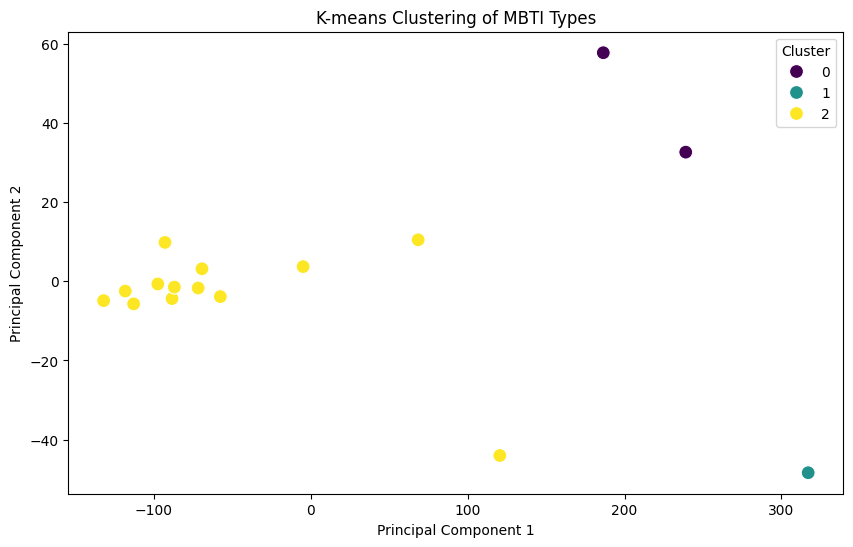

In [132]:
features_for_pca = df_data_features.drop(['MBTI', 'Cluster'], axis=1)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_for_pca)

pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = df_data_features['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=100)
plt.title('K-means Clustering of MBTI Types')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [133]:
# Printing MBTI types in each cluster

for cluster_id in df_data_features['Cluster'].unique():
    cluster_mbti_types = df_data_features.loc[df_data_features['Cluster'] == cluster_id, 'MBTI'].tolist()
    print(f'Cluster {cluster_id}: {cluster_mbti_types}')

Cluster 0: ['infj', 'intp']
Cluster 2: ['entp', 'enfp', 'infp', 'esfp', 'estp', 'isfp', 'enfj', 'istj', 'istp', 'isfj', 'entj', 'estj', 'esfj']
Cluster 1: ['intj']


In [134]:
# Setting thresholds for minimum and maximum word occurrence
min_word_occurrence = 5
max_word_occurrence = 200

filtered_mbti_dating_words_dict = {
    mbti_label: {word: count for word, count in word_counts.items() if min_word_occurrence <= count <= max_word_occurrence}
    for mbti_label, word_counts in mbti_dating_words_dict.items()
}

In [135]:
#mbti_dating_words_dict = filtered_mbti_dating_words_dict

In [136]:
rows = []

for mbti_label, word_counts in filtered_mbti_dating_words_dict.items():
    row = {'MBTI': mbti_label, **word_counts}
    rows.append(row)

df_data_features_filtered = pd.DataFrame(rows)
df_data_features_filtered.fillna(0,inplace=True)

In [137]:
data_features_filtered = df_data_features_filtered.drop('MBTI', axis=1)

scaled_data = StandardScaler().fit_transform(data_features_filtered)

# 3 clusters
n_clusters = 3

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_data_features_filtered['Cluster'] = kmeans.fit_predict(scaled_data)

# Display the DataFrame with the cluster assignments
print(df_data_features_filtered)

    MBTI  luck  wonder  passion   love  good  humor  concern  strong  respect  \
0   infj   6.0    27.0     16.0   98.0    89    8.0      9.0    25.0     11.0   
1   entp   0.0     9.0      5.0   33.0    38    8.0      0.0     8.0      0.0   
2   enfp   0.0    16.0     10.0   67.0    56    0.0      0.0    22.0      0.0   
3   intj   7.0    20.0     16.0  128.0    87   31.0     12.0    27.0     18.0   
4   infp   0.0    14.0     15.0   48.0    42    0.0      0.0    13.0      0.0   
5   esfp   0.0     0.0      0.0   11.0    11    0.0      0.0     0.0      0.0   
6   estp   0.0     0.0      0.0    0.0    10    0.0      0.0     0.0      0.0   
7   intp   0.0    21.0      7.0   84.0    72    9.0      7.0    18.0      7.0   
8   isfp   0.0     0.0      0.0   17.0    16    0.0      0.0     0.0      0.0   
9   enfj   0.0     0.0      0.0   10.0    10    0.0      0.0     0.0      0.0   
10  istj   0.0     0.0      0.0   12.0    18    0.0      0.0     0.0      0.0   
11  istp   0.0     0.0      

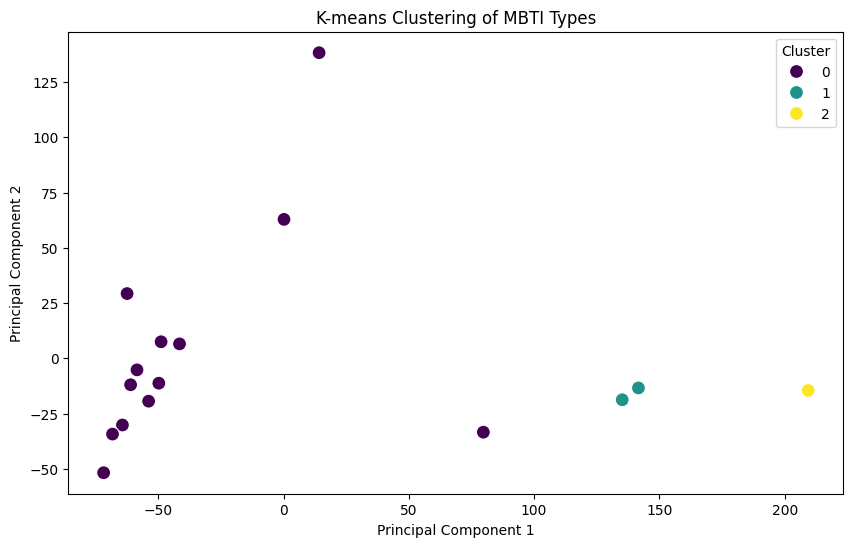

In [138]:
features_for_pca_filtered = df_data_features_filtered.drop(['MBTI', 'Cluster'], axis=1)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_for_pca_filtered)

pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = df_data_features_filtered['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=100)
plt.title('K-means Clustering of MBTI Types')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [139]:
# Printing MBTI types in each cluster

for cluster_id in df_data_features_filtered['Cluster'].unique():
    cluster_mbti_types = df_data_features_filtered.loc[df_data_features_filtered['Cluster'] == cluster_id, 'MBTI'].tolist()
    print(f'Cluster {cluster_id}: {cluster_mbti_types}')

Cluster 1: ['infj', 'intp']
Cluster 0: ['entp', 'enfp', 'infp', 'esfp', 'estp', 'isfp', 'enfj', 'istj', 'istp', 'isfj', 'entj', 'estj', 'esfj']
Cluster 2: ['intj']
